In [1]:
import os, sys, mne, socket, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nilearn import plotting
from itertools import product

# Decoding tools
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    GeneralizingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from initialization import load_paths
from preprocFuncs import getRawData, getTrials
# from plotters import plotPower, plotRSA, plotDiffRSA
from decodeHelpers import *
import mneALI_trends

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Compare Alpha lateralization by error

In [10]:
subjList = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
ALI_good = []
ALI_bad = []
t_array = []
for subjID in subjList:
    ALI_goodTHIS, ALI_badTHIS, t_arrayTHIS = mneALI_trends.main(subjID)
    ALI_good.append(ALI_goodTHIS)
    ALI_bad.append(ALI_badTHIS)
    t_array.append(t_arrayTHIS)

Loading pre-existing data ...
Opening raw data file /d/DATD/datd/MD_TMS_EEG/EEGpy/sub01/day02/sub01_day02_raw.fif...
    Range : 0 ... 4036319 =      0.000 ...  4036.319 secs
Ready.
Reading 0 ... 4036319  =      0.000 ...  4036.319 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Loading pre-existing data ...
Opening raw data file

In [29]:
ALI_bad_orig = ALI_bad.copy()
# ALI_bad = ALI_bad - ALI_good
ALI

In [34]:
ALI_bad = ALI_bad_orig.copy()

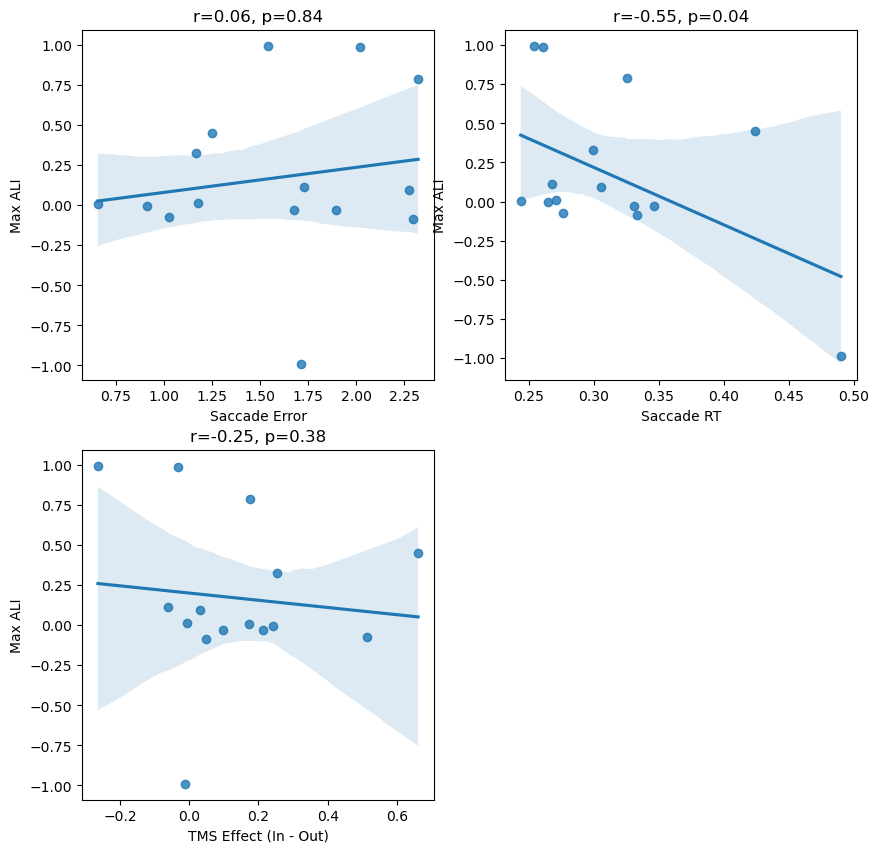

In [35]:
from scipy.stats import pearsonr
saccErr = []
saccRT = []
TMSEff = []
master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_all5_filtered.csv')
t = t_array[0]
# Find index of t closest to 0
t0 = np.argmin(np.abs(t))
# Find index of t closest to 1
t1 = np.argmin(np.abs(t-1))

for subjID in subjList:
    day = master_df[(master_df['subjID'] == subjID) & (master_df['istms']==0)]['day'].unique()[0]
    # Select data for this subejct for targets inside PF only for prosaccade blocks
    thisDF = master_df[(master_df['subjID'] == subjID) & (master_df['instimVF']==1) & (master_df['istms']==0) & (master_df['ispro']==1)]
    thisDF_TMSin = master_df[(master_df['subjID'] == subjID) & (master_df['instimVF']==1) & (master_df['istms']==1) & (master_df['ispro']==1)]
    thisDF_TMSout = master_df[(master_df['subjID'] == subjID) & (master_df['instimVF']==1) & (master_df['istms']==0) & (master_df['ispro']==1)]
    saccErr.append(thisDF['ierr'].mean())
    saccRT.append(thisDF['isacc_rt'].mean())
    TMSEff.append(thisDF_TMSin['ierr'].mean() - thisDF_TMSout['ierr'].mean())

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# plt.plot(saccErr, np.max(ALI_bad[:, t0:t1], axis=1), 'o')
dfTemp = pd.DataFrame({'saccErr': saccErr, 'maxALI': np.max(ALI_bad[:, t0:t1], axis=1)})
sns.regplot(x='saccErr', y='maxALI', data=dfTemp)
r, p = pearsonr(saccErr, np.min(ALI_bad[:, t0:t1], axis=1))
plt.xlabel('Saccade Error')
plt.ylabel('Max ALI')
plt.title(f'r={r:.2f}, p={p:.2f}')

plt.subplot(2, 2, 2)
dfTemp = pd.DataFrame({'saccRT': saccRT, 'maxALI': np.max(ALI_bad[:, t0:t1], axis=1)})
sns.regplot(x='saccRT', y='maxALI', data=dfTemp)
r, p = pearsonr(saccRT, np.min(ALI_bad[:, t0:t1], axis=1))
# plt.plot(saccRT, np.max(ALI_bad[:, t0:t1], axis=1), 'o')
plt.xlabel('Saccade RT')
plt.ylabel('Max ALI')
plt.title(f'r={r:.2f}, p={p:.2f}')

plt.subplot(2, 2, 3)
# plt.plot(TMSEff, np.max(ALI_bad[:, t0:t1], axis=1), 'o')
dfTemp = pd.DataFrame({'TMSEff': TMSEff, 'maxALI': np.max(ALI_bad[:, t0:t1], axis=1)})
sns.regplot(x='TMSEff', y='maxALI', data=dfTemp)
r, p = pearsonr(TMSEff, np.min(ALI_bad[:, t0:t1], axis=1))
plt.xlabel('TMS Effect (In - Out)')
plt.ylabel('Max ALI')
plt.title(f'r={r:.2f}, p={p:.2f}')
# plt.aspect('equal', 'box')

plt.show()

In [20]:
t_array[0] > 0 & t_array[0] < 1

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.43436068122523763
-0.2945804756129938
-0.23750203375368217
-0.5177892789377516
-0.4512250845917187
-0.24730004466272779
-0.9993320710898488
-0.20493869817945973
-0.3398677357387468
0.7006161837438516
-0.22228016055834923
-0.23251266865255465
0.1883757081873855
-0.15362028254687352
-0.12762837791107523


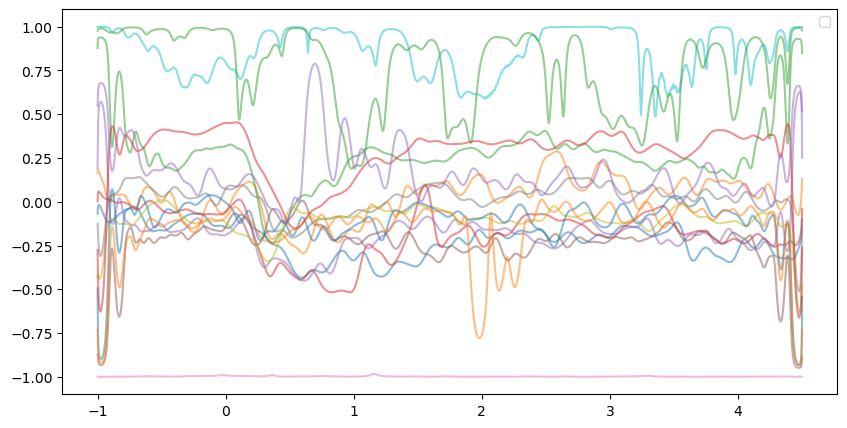

In [37]:
ALI_bad = np.array(ALI_bad)
ALI_good = np.array(ALI_good)
plt.figure(figsize=(10, 5))
# plt.plot(t_array[0], np.mean(ALI_good, axis=0), label='Good')
# plt.plot(t_array[0], np.mean(ALI_bad, axis=0), label='Bad')
y_good = np.mean(ALI_good, axis=0)
y_bad = np.mean(ALI_bad, axis=0)
y_good_err = np.std(ALI_good, axis=0)/np.sqrt(len(subjList))
y_bad_err = np.std(ALI_bad, axis=0)/np.sqrt(len(subjList))
for i in range(len(subjList)):
    # plt.plot(t_array[0], ALI_good[i], 'b', alpha=0.5)
    plt.plot(t_array[0], ALI_bad[i], alpha=0.5)
    print(ALI_bad[i, t0:t1].min())
# plt.plot(t_array[0], y_good, label='Good')
# plt.fill_between(t_array[0], y_good-y_good_err, y_good+y_good_err, alpha=0.5)
# plt.plot(t_array[0], y_bad, label='Bad')
# plt.fill_between(t_array[0], y_bad-y_bad_err, y_bad+y_bad_err, alpha=0.5)
# plt.errorbar(t_array[0], np.mean(ALI_good, axis=0), yerr=np.std(ALI_good, axis=0)/np.sqrt(len(subjList)), label='Good', alpha=0.5)
# plt.errorbar(t_array[0], np.mean(ALI_bad, axis=0), yerr=np.std(ALI_bad, axis=0)/np.sqrt(len(subjList)), label='Bad', alpha=0.5)
plt.legend()
plt.show()

In [2]:
# subjList = [1, 3, 5, 6, 7, 12, 14, 17, 23]
subjList = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]

scores_notms_meta = None
t_down_notms_meta = None
scores_tms_meta = None
t_down_tms_meta = None

for subjID in subjList:
    print(f"Running subject {subjID}")
    master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/master_df_calib.csv')
    notmsday = master_df[(master_df['subjID'] == subjID) & (master_df['istms']==0)]['day'].unique()[0]
    days_valid = [1, 2, 3]
    tmsdays = [day for day in days_valid if day != notmsday]
    tmsday = tmsdays[-1]

    freq_band = 'alpha'
    POWPHASE = ['pow', 'phase']
    TYPECOND = ['byPF_pro', 'byPF_anti', 'byPF_stimin', 'byPF_respin', 'byTrlType']
    pow_or_phase = 'pow'
    typeCond = 'byPF_pro'

    p = load_paths(subjID, notmsday)
    data = np.load(f"{p['EEGroot']}_{pow_or_phase}_{typeCond}.npy.npz")
    scores_mean = data['scores_mean']
    t_down = data['t_array_down']

    if scores_notms_meta is None:
        scores_notms_meta = scores_mean[:, :, np.newaxis]
        t_down_notms_meta = t_down[:, np.newaxis]
    else:
        scores_notms_meta = np.concatenate((scores_notms_meta, scores_mean[:,:,np.newaxis]), axis=2)
        t_down_notms_meta = np.concatenate((t_down_notms_meta, t_down[:, np.newaxis]), axis=1)

    p = load_paths(subjID, tmsday)
    data = np.load(f"{p['EEGroot']}_{pow_or_phase}_{typeCond}.npy.npz")
    scores_mean = data['scores_mean']
    t_down = data['t_array_down']

    if scores_tms_meta is None:
        scores_tms_meta = scores_mean[:, :, np.newaxis]
        t_down_tms_meta = t_down[:, np.newaxis]
    else:
        scores_tms_meta = np.concatenate((scores_tms_meta, scores_mean[:,:,np.newaxis]), axis=2)
        t_down_tms_meta = np.concatenate((t_down_tms_meta, t_down[:, np.newaxis]), axis=1)    

t_array_notms_down = np.mean(t_down_notms_meta, axis=1)
t_array_tms_down = np.mean(t_down_tms_meta, axis=1)

Running subject 1
Running subject 3
Running subject 5
Running subject 6
Running subject 7
Running subject 10
Running subject 12
Running subject 14
Running subject 15
Running subject 17
Running subject 22
Running subject 23
Running subject 25
Running subject 26
Running subject 27


In [4]:
scores_mean.shape

(109, 109)

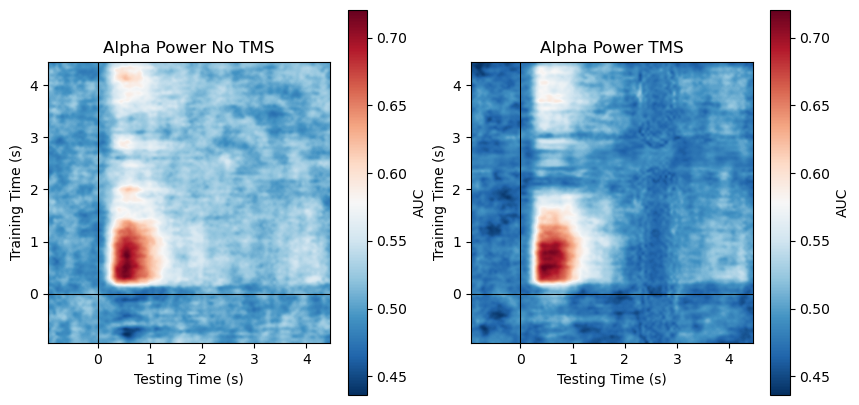

In [3]:
from scipy.stats import circmean
f, axs = plt.subplots(1, 2, figsize=(10, 5))
im = axs[0].imshow(scores_notms_meta.mean(axis=2), 
               interpolation='lanczos', 
               origin='lower', 
               cmap='RdBu_r', 
               extent=[t_array_notms_down[0], t_array_notms_down[-1], t_array_notms_down[0], t_array_notms_down[-1]],
               )
axs[1].imshow(scores_tms_meta.mean(axis=2),
                interpolation='lanczos', 
                origin='lower', 
                cmap='RdBu_r', 
                extent=[t_array_tms_down[0], t_array_tms_down[-1], t_array_tms_down[0], t_array_tms_down[-1]],
                )
# im = axs[0].imshow(circmean(scores_notms_meta, axis=2),
#                interpolation='lanczos', 
#                origin='lower', 
#                cmap='RdBu_r', 
#                extent=[t_array_notms_down[0], t_array_notms_down[-1], t_array_notms_down[0], t_array_notms_down[-1]],
#                )
# axs[1].imshow(circmean(scores_tms_meta, axis=2),
#                 interpolation='lanczos', 
#                 origin='lower', 
#                 cmap='RdBu_r', 
#                 extent=[t_array_tms_down[0], t_array_tms_down[-1], t_array_tms_down[0], t_array_tms_down[-1]],
#                 )
axs[0].set_title('Alpha Power No TMS')
axs[1].set_title('Alpha Power TMS')
for ax in axs:
    ax.axhline(0, color='k', lw=0.8)
    ax.axvline(0, color='k', lw=0.8)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('AUC')
plt.show()

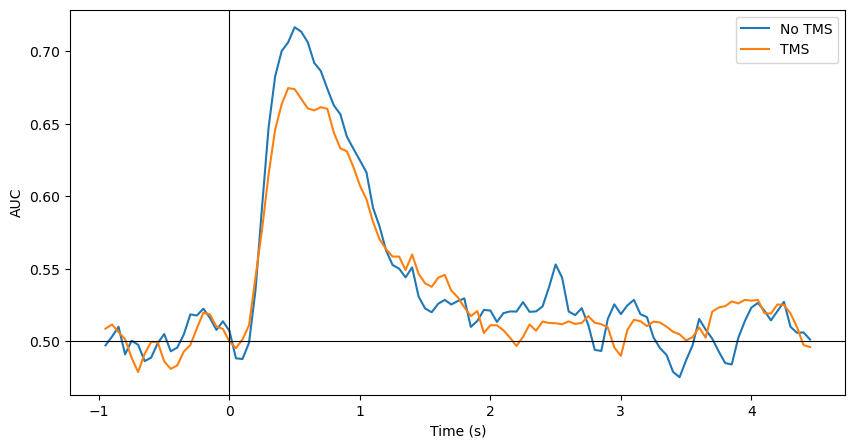

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(t_array_notms_down, scores_notms_meta.mean(axis=2).diagonal(), label='No TMS')
plt.plot(t_array_tms_down, scores_tms_meta.mean(axis=2).diagonal(), label='TMS')

plt.axhline(0.5, color='k', lw=0.8)
plt.axvline(0, color='k', lw=0.8)
plt.xlabel('Time (s)')
plt.ylabel('AUC')
plt.legend()
plt.show()

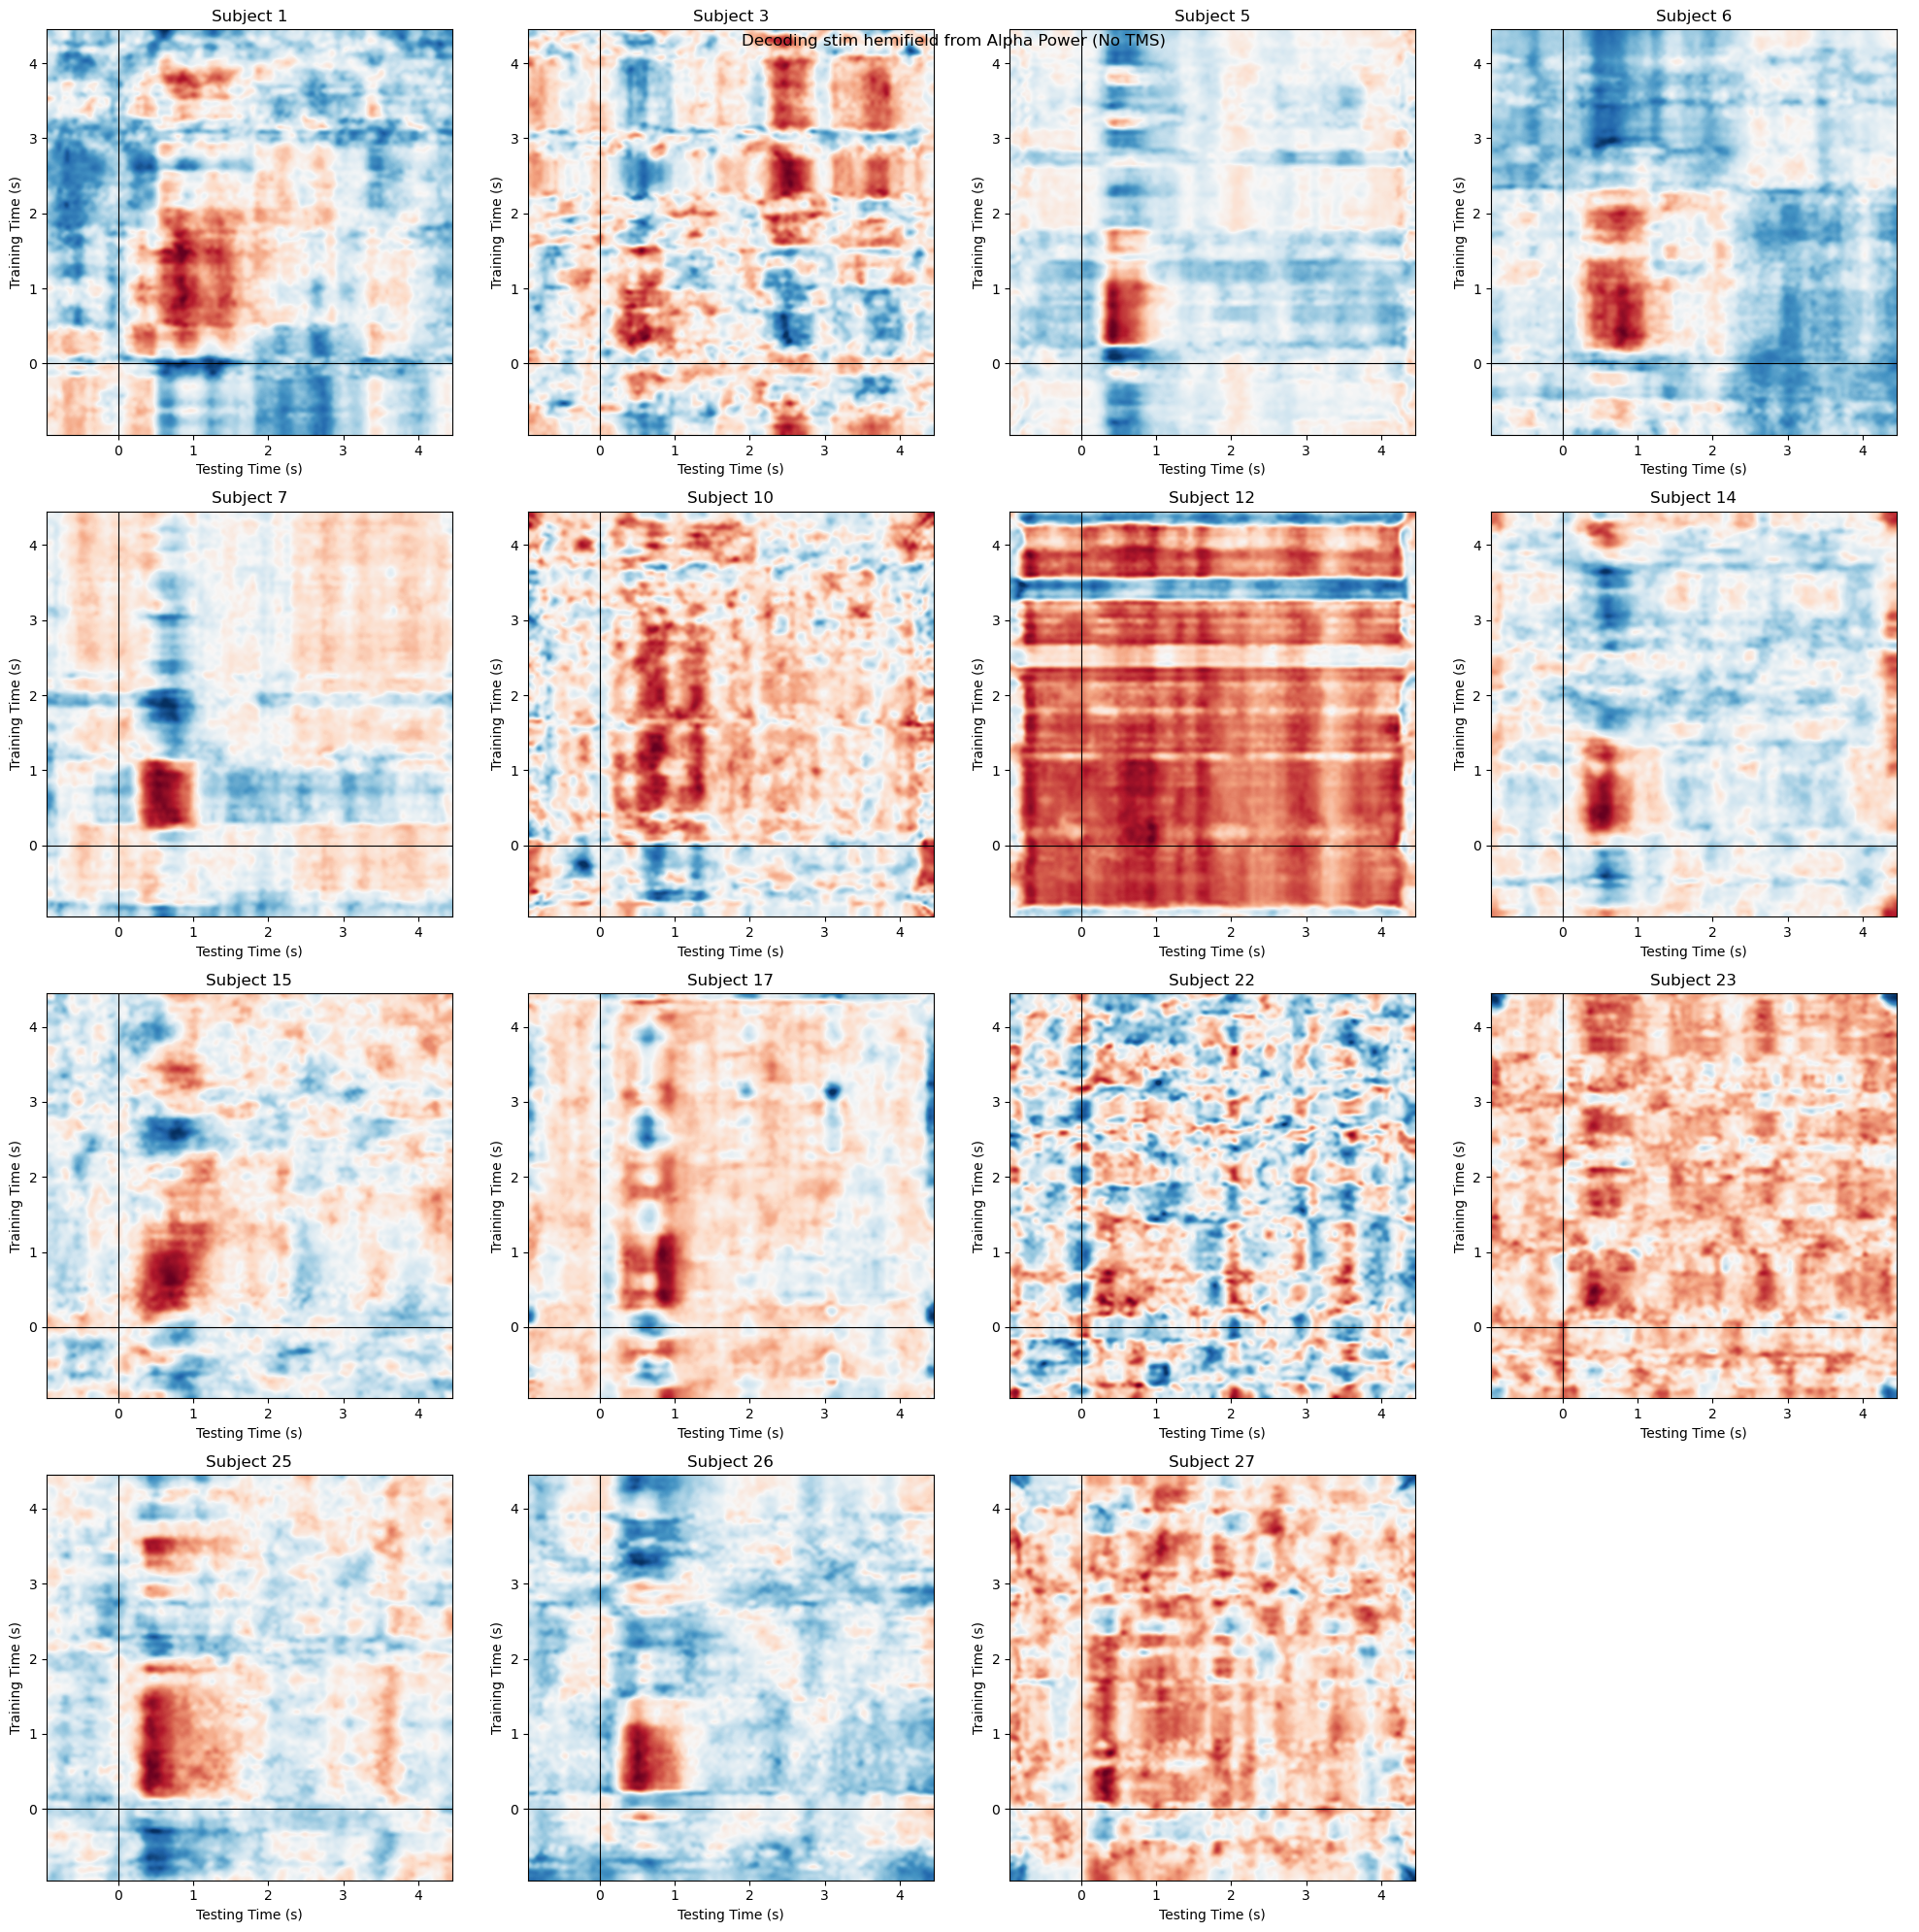

In [7]:
nsubs = scores_notms_meta.shape[2]
ncols = 4
nrows = int(np.ceil(nsubs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < nsubs:
        ax.imshow(scores_notms_meta[:, :, i], 
                  interpolation='lanczos', 
                  origin='lower', 
                  cmap='RdBu_r', 
                  extent=[t_array_notms_down[0], t_array_notms_down[-1], t_array_notms_down[0], t_array_notms_down[-1]],
                  )
        ax.axhline(0, color='k', lw=0.8)
        ax.axvline(0, color='k', lw=0.8)
        ax.set_xlabel('Testing Time (s)')
        ax.set_ylabel('Training Time (s)')
        ax.set_title(f'Subject {subjList[i]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.suptitle('Decoding stim hemifield from Alpha Power (No TMS)')
plt.show()

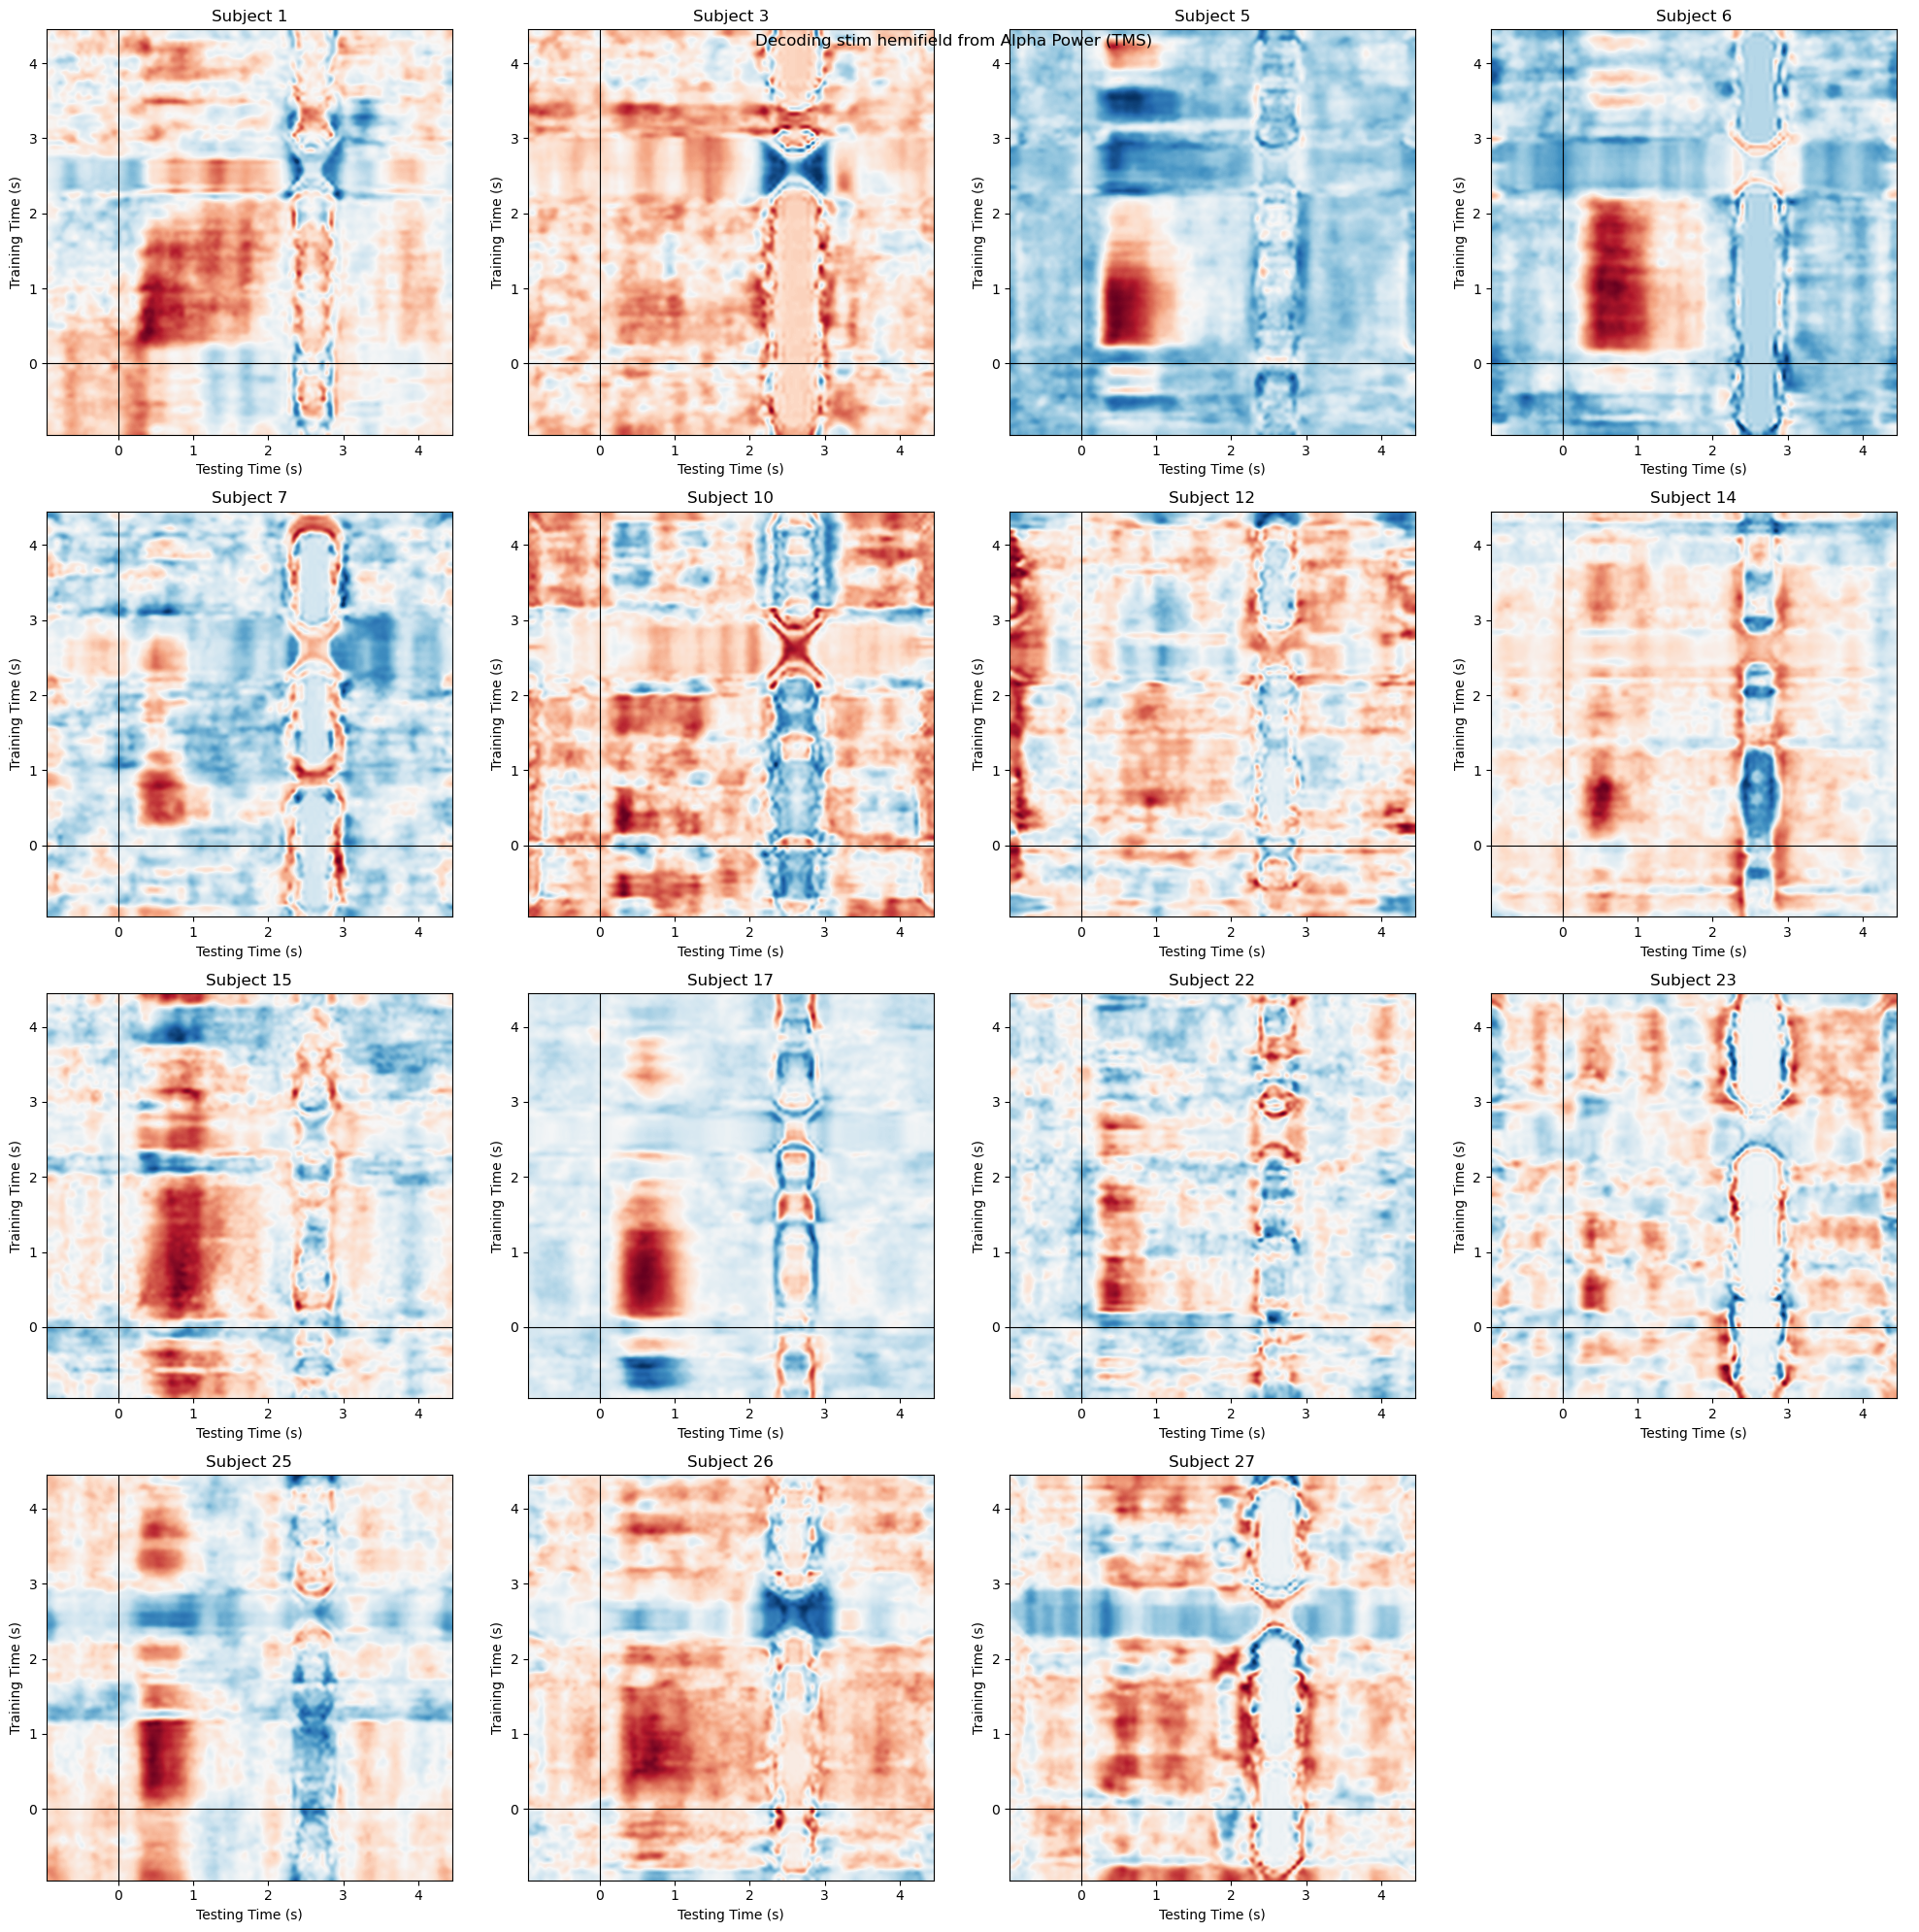

In [8]:
nsubs = scores_tms_meta.shape[2]
ncols = 4
nrows = int(np.ceil(nsubs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < nsubs:
        ax.imshow(scores_tms_meta[:, :, i], 
                  interpolation='lanczos', 
                  origin='lower', 
                  cmap='RdBu_r', 
                  extent=[t_array_tms_down[0], t_array_tms_down[-1], t_array_tms_down[0], t_array_tms_down[-1]],
                  )
        ax.axhline(0, color='k', lw=0.8)
        ax.axvline(0, color='k', lw=0.8)
        ax.set_xlabel('Testing Time (s)')
        ax.set_ylabel('Training Time (s)')
        ax.set_title(f'Subject {subjList[i]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.suptitle('Decoding stim hemifield from Alpha Power (TMS)')
plt.show()